<a href="https://colab.research.google.com/github/AsadShibli/satellite-image-download-automation/blob/main/Satellite_Image_Processing_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [ ]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='earth-project21')

## Test the API

Test the API by printing the elevation of Mount Everest.

In [5]:
import ee
import folium
from datetime import datetime

# Initialize Earth Engine
ee.Initialize()

# Define constants
START_DATE = '2019-01-01'
END_DATE = '2019-03-01'
MAX_CLOUD_PROBABILITY = 65
region = ee.Geometry.Rectangle([-76.5, 2.0, -74, 4.0], proj='EPSG:4326', geodesic=False)

# Load Sentinel-2 surface reflectance and cloud probability collections
s2Sr = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
s2Clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

# Function to mask clouds based on cloud probability
def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Function to mask edges using 20m and 60m bands
def maskEdges(s2_img):
    return s2_img.updateMask(
        s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# Filter input collections by desired data range and region
criteria = ee.Filter.And(
    ee.Filter.bounds(region),
    ee.Filter.date(START_DATE, END_DATE)
)
s2Sr = s2Sr.filter(criteria).map(maskEdges)
s2Clouds = s2Clouds.filter(criteria)

# Join S2 SR with cloud probability dataset to add cloud mask
s2SrWithCloudMask = ee.Join.saveFirst('cloud_mask').apply(
    primary=s2Sr,
    secondary=s2Clouds,
    condition=ee.Filter.equals(leftField='system:index', rightField='system:index')
)

# Apply cloud mask and calculate median
s2CloudMasked = ee.ImageCollection(s2SrWithCloudMask).map(maskClouds).median()

# Define visualization parameters
rgbVis = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

# Create a folium map
map_center = [3.0, -75.0]
my_map = folium.Map(location=map_center, zoom_start=12)

# Add the masked image to the map
masked_image = s2CloudMasked.visualize(**rgbVis)
masked_image_url = masked_image.getMapId()['tile_fetcher'].url_format

folium.TileLayer(
    tiles=masked_image_url,
    attr='Google Earth Engine',
    name='S2 SR masked',
    overlay=True,
    control=True
).add_to(my_map)

# Add layer control to the map
folium.LayerControl().add_to(my_map)

# Display the map
my_map


## Based on Client Requirement

# Code for Download

In [16]:
import ee
import folium
import time

# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project='earth-project21')

# Example AOI for a coastal area (San Francisco Bay)
aoi_coastal = ee.Geometry.Polygon(
    [[[-123.2, 37.6], [-123.2, 38.2], [-122.1, 38.2], [-122.1, 37.6], [-123.2, 37.6]]])

# Example AOI for a port (Port of Los Angeles)
aoi_port = ee.Geometry.Polygon(
    [[[-118.32, 33.68], [-118.32, 33.82], [-118.17, 33.82], [-118.17, 33.68], [-118.32, 33.68]]])

def search_sentinel2(aoi):
    return (ee.ImageCollection('COPERNICUS/S2')
            .filterBounds(aoi)
            .filterDate('2023-01-01', '2023-12-31')
            .sort('CLOUDY_PIXEL_PERCENTAGE'))

# Function to export image to Google Drive
def export_image_to_drive(image, description, crs, transform, region):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        crs=crs,
        crsTransform=transform,
        region=region,
    )
    task.start()

    # Monitor the task status
    print(f'Exporting image {description}...')
    while task.active():
        print('Task is active...')
        time.sleep(30)  # Wait for 30 seconds
    print('Export completed.')

# Function to create a folium map with AOI
def create_map_with_aoi(aoi, center, zoom_start=10):
    # Create a folium map centered at the given location
    folium_map = folium.Map(location=center, zoom_start=zoom_start)

    # Add the AOI to the map
    folium.GeoJson(data=aoi.getInfo()).add_to(folium_map)

    return folium_map

# Example usage:
aoi = aoi_coastal  # Use the coastal AOI
image_collection = search_sentinel2(aoi)
image = image_collection.first()

# Visualize the AOI on a map
center = [37.9, -122.65]  # Center of the San Francisco Bay AOI
folium_map = create_map_with_aoi(aoi, center)
folium_map.save('aoi_map.html')
print('AOI map saved as aoi_map.html')

# Display the map (if running in a Jupyter notebook or similar environment)
# folium_map

if image is not None:
    # Select a single band with a consistent projection
    image = image.select('B4')  # Selecting Red band (Band 4) as an example

    # Define projection parameters (CRS and transform)
    projection = {
        'crs': image.projection().crs(),
        'transform': image.projection().getInfo()['transform']
    }

    # Define the region of interest (geometry)
    geometry = aoi

    # Export the image to Google Drive
    export_image_to_drive(image, 'sentinel2_image_to_drive', projection['crs'], projection['transform'], geometry)
else:
    print("No images found for the specified area and date range.")


AOI map saved as aoi_map.html
Exporting image sentinel2_image_to_drive...
Task is active...
Task is active...
Task is active...


KeyboardInterrupt: 

## Converting to PNG file

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install rasterio matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 25.8 MB/s eta 0:00:00


In [23]:
import rasterio

# Path to your .tiff file
tiff_file = '/content/drive/MyDrive/projects/Miami_Coastal_Area.tif'

# Open the .tiff file and print its metadata
with rasterio.open(tiff_file) as src:
    print(src.meta)
    print("Number of bands:", src.count)
    print("Band descriptions:", src.descriptions)

    # Print the data type of each band
    for i in range(1, src.count + 1):
        print(f"Band {i} data type: {src.dtypes[i-1]}")


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 780, 'height': 557, 'count': 23, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -80.19000029902574,
       0.0, -8.983152841195215e-05, 25.82000671686217)}
Number of bands: 23
Band descriptions: ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60')
Band 1 data type: float64
Band 2 data type: float64
Band 3 data type: float64
Band 4 data type: float64
Band 5 data type: float64
Band 6 data type: float64
Band 7 data type: float64
Band 8 data type: float64
Band 9 data type: float64
Band 10 data type: float64
Band 11 data type: float64
Band 12 data type: float64
Band 13 data type: float64
Band 14 data type: float64
Band 15 data type: float64
Band 16 data type: float64
Band 17 data type: float64
Band 18 data type: float64
Band 19 data type: float64
Band 20 data type: float64
Band

Red band - min: 0.0 max: 255.0 mean: 69.5482783225153
Green band - min: 0.0 max: 255.0 mean: 84.93203056668048
Blue band - min: 0.0 max: 255.0 mean: 72.01620172167749


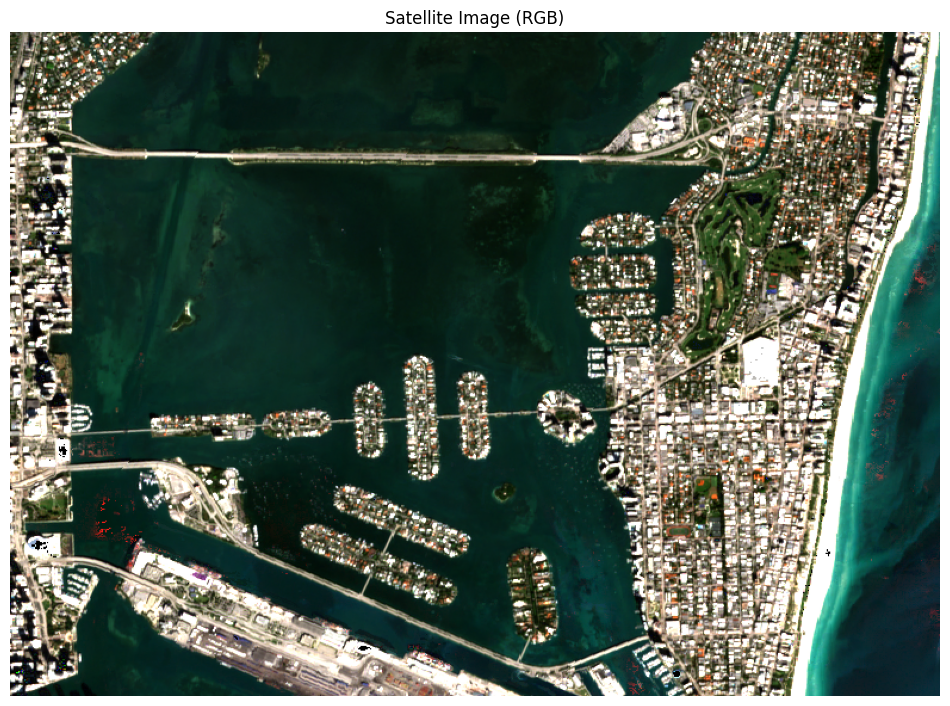

In [26]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your .tiff file
tiff_file = '/content/drive/MyDrive/projects/Miami_Coastal_Area.tif'

# Open the .tiff file
with rasterio.open(tiff_file) as src:
    # Read the bands corresponding to TCI_R, TCI_G, TCI_B
    red_band = src.read(16)
    green_band = src.read(17)
    blue_band = src.read(18)

    # Mask NaN values
    red_band = np.nan_to_num(red_band, nan=0.0)
    green_band = np.nan_to_num(green_band, nan=0.0)
    blue_band = np.nan_to_num(blue_band, nan=0.0)

    # Print statistics for debugging
    print("Red band - min:", red_band.min(), "max:", red_band.max(), "mean:", red_band.mean())
    print("Green band - min:", green_band.min(), "max:", green_band.max(), "mean:", green_band.mean())
    print("Blue band - min:", blue_band.min(), "max:", blue_band.max(), "mean:", blue_band.mean())

    # Normalize the bands using min-max normalization
    def min_max_normalize(band):
        band_min, band_max = band.min(), band.max()
        return (band - band_min) / (band_max - band_min)

    red_band_norm = min_max_normalize(red_band)
    green_band_norm = min_max_normalize(green_band)
    blue_band_norm = min_max_normalize(blue_band)

    # Stack bands into an RGB image
    rgb_normalized = np.dstack((red_band_norm, green_band_norm, blue_band_norm))

    # Plot the normalized RGB image
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(rgb_normalized)
    ax.set_title('Satellite Image (RGB)')
    ax.axis('off')
    plt.show()


## Modification

Red band - min: 0.0 max: 255.0 mean: 69.5482783225153
Green band - min: 0.0 max: 255.0 mean: 84.93203056668048
Blue band - min: 0.0 max: 255.0 mean: 72.01620172167749


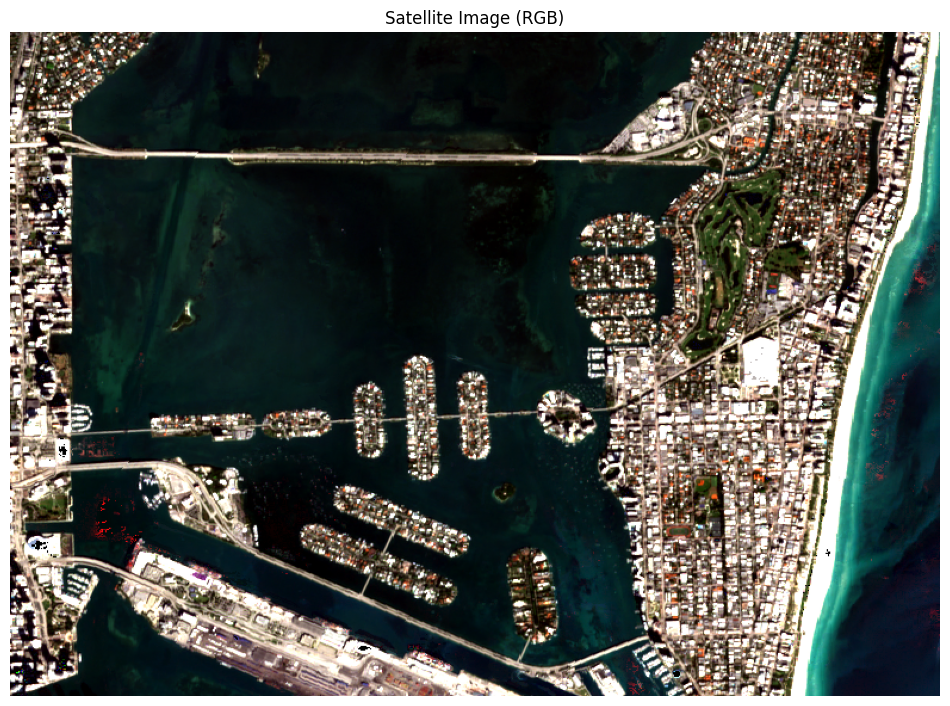

In [29]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your .tiff file
tiff_file = '/content/drive/MyDrive/projects/Miami_Coastal_Area.tif'

# Open the .tiff file
with rasterio.open(tiff_file) as src:
    # Read the bands corresponding to TCI_R, TCI_G, TCI_B
    red_band = src.read(16)
    green_band = src.read(17)
    blue_band = src.read(18)

    # Mask NaN values
    red_band = np.nan_to_num(red_band, nan=0.0)
    green_band = np.nan_to_num(green_band, nan=0.0)
    blue_band = np.nan_to_num(blue_band, nan=0.0)

    # Print statistics for debugging
    print("Red band - min:", red_band.min(), "max:", red_band.max(), "mean:", red_band.mean())
    print("Green band - min:", green_band.min(), "max:", green_band.max(), "mean:", green_band.mean())
    print("Blue band - min:", blue_band.min(), "max:", blue_band.max(), "mean:", blue_band.mean())

    # Normalize the bands using percentile clipping
    def normalize_band(band):
        p2, p98 = np.percentile(band, (2, 98))
        band = np.clip(band, p2, p98)
        return (band - p2) / (p98 - p2)

    red_band_norm = normalize_band(red_band)
    green_band_norm = normalize_band(green_band)
    blue_band_norm = normalize_band(blue_band)

    # Stack bands into an RGB image
    rgb_normalized = np.dstack((red_band_norm, green_band_norm, blue_band_norm))

    # Plot the normalized RGB image
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(rgb_normalized)
    ax.set_title('Satellite Image (RGB)')
    ax.axis('off')
    plt.show()


In [31]:
!pip install schedule


## Final Code

In [32]:
import ee
import folium
import time
import schedule
import logging
from datetime import datetime, timedelta
import json
import os

# Set up logging
logging.basicConfig(filename='satellite_image_download.log', level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')

# File to track the last download date
LAST_DOWNLOAD_FILE = 'last_download_date.json'

def authenticate_ee():
    try:
        ee.Authenticate()
        ee.Initialize(project='earth-project21')
        logging.info("Authenticated and initialized Earth Engine.")
    except Exception as e:
        logging.error(f"Error during authentication: {e}")

def read_last_download_date():
    if os.path.exists(LAST_DOWNLOAD_FILE):
        with open(LAST_DOWNLOAD_FILE, 'r') as file:
            data = json.load(file)
        return datetime.strptime(data['last_download_date'], '%Y-%m-%d')
    else:
        # Default to a past date if no date is recorded
        return datetime(datetime.now().year, 1, 1)

def write_last_download_date(date):
    with open(LAST_DOWNLOAD_FILE, 'w') as file:
        json.dump({'last_download_date': date.strftime('%Y-%m-%d')}, file)

def search_sentinel2(aoi, start_date, end_date):
    return (ee.ImageCollection('COPERNICUS/S2')
            .filterBounds(aoi)
            .filterDate(start_date, end_date)
            .sort('CLOUDY_PIXEL_PERCENTAGE'))

def export_image_to_drive(image, description, crs, transform, region):
    try:
        task = ee.batch.Export.image.toDrive(
            image=image,
            description=description,
            crs=crs,
            crsTransform=transform,
            region=region,
        )
        task.start()

        logging.info(f'Exporting image {description}...')
        while task.active():
            logging.info('Task is active...')
            time.sleep(30)
        logging.info('Export completed.')
    except Exception as e:
        logging.error(f"Error during export: {e}")

def create_map_with_aoi(aoi, center, zoom_start=10):
    folium_map = folium.Map(location=center, zoom_start=zoom_start)
    folium.GeoJson(data=aoi.getInfo()).add_to(folium_map)
    return folium_map

def process_aoi(aoi, center, last_download_date):
    today = datetime.now().date()
    start_date = last_download_date.strftime('%Y-%m-%d')
    end_date = today.strftime('%Y-%m-%d')

    image_collection = search_sentinel2(aoi, start_date, end_date)
    image_list = image_collection.toList(image_collection.size())
    num_images = image_list.size().getInfo()

    if num_images > 0:
        for i in range(num_images):
            image = ee.Image(image_list.get(i))
            image_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            logging.info(f'Processing image from date: {image_date}')
            image = image.select('B4')
            projection = {
                'crs': image.projection().crs(),
                'transform': image.projection().getInfo()['transform']
            }
            geometry = aoi
            description = f'sentinel2_image_{image_date}'
            export_image_to_drive(image, description, projection['crs'], projection['transform'], geometry)
        write_last_download_date(today)
    else:
        logging.warning("No new images found for the specified area and date range.")

def main():
    authenticate_ee()

    last_download_date = read_last_download_date()

    aoi_coastal = ee.Geometry.Polygon(
        [[[-123.2, 37.6], [-123.2, 38.2], [-122.1, 38.2], [-122.1, 37.6], [-123.2, 37.6]]])
    aoi_port = ee.Geometry.Polygon(
        [[[-118.32, 33.68], [-118.32, 33.82], [-118.17, 33.82], [-118.17, 33.68], [-118.32, 33.68]]])

    center_coastal = [37.9, -122.65]
    center_port = [33.75, -118.25]

    process_aoi(aoi_coastal, center_coastal, last_download_date)
    process_aoi(aoi_port, center_port, last_download_date)

# Schedule the job to run every day at a specific time
schedule.every().day.at("00:00").do(main)

logging.info("Script started. Waiting to run the scheduled job...")

while True:
    schedule.run_pending()
    time.sleep(60)  # wait one minute


KeyboardInterrupt: 